In [110]:
import pandas as pd
from collections import Counter
from tqdm import tqdm
import math
import re
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import pandas as pd
import numpy as np

In [111]:
# Load real and fake BuzzFeed datasets
df_real = pd.read_csv('../data/raw/FakeNewsNet/BuzzFeed_real_news_content.csv')
df_fake = pd.read_csv('../data/raw/FakeNewsNet/BuzzFeed_fake_news_content.csv')

In [112]:

# Concatenate them into a full dataset
df_full = pd.concat([df_real, df_fake], ignore_index=True)

# Append news_id from PolitiFactNews.txt
with open('../data/raw/FakeNewsNet/BuzzFeedNews.txt', 'r') as file:
    news_ids = [line.strip() for line in file]

df_full["news_id"] = news_ids

# Load train and test id's
with open('../data/processed/FakeNewsNet/BuzzFeed_trainIds.txt', 'r') as file:
    train_values = [line.strip() for line in file]
with open('../data/processed/FakeNewsNet/BuzzFeed_testIds.txt', 'r') as file:
    test_values = [line.strip() for line in file]

# Create train and test data sets
df_train = df_full[df_full['news_id'].isin(train_values)].reset_index(drop=True)
df_test = df_full[df_full['news_id'].isin(test_values)].reset_index(drop=True)


df_train["full_text"] = df_train["title"] + " " + df_train["text"]
df_test["full_text"] = df_test["title"] + " " + df_test["text"]

# Create a label column stating whether the news is fake or real based on the news_id column
df_train["label"] = df_train["news_id"].apply(lambda x: 0 if x.split("_")[1].lower() == "fake" else 1)
df_test["label"] = df_test["news_id"].apply(lambda x: 0 if x.split("_")[1].lower() == "fake" else 1)


In [113]:
# Download the stopwords dataset
nltk.download('stopwords', quiet=True)

def tokenize(text, stemmer, stop_words):
    """Tokenize text, stem, and remove stop words."""
    tokens = re.findall(r'\b\w+\b', text.lower())
    return [stemmer.stem(token) for token in tokens if token not in stop_words]

def compute_tfidf_train(df, column_name):
    stemmer = PorterStemmer()
    stop_words = set(stopwords.words('english'))

    # Tokenize, stem and compute term frequency for each document
    df['tf'] = df[column_name].apply(lambda x: Counter(tokenize(x, stemmer, stop_words)))

    # Create a list of all unique words in the corpus
    all_unique_words = list(set(word for tf in df['tf'] for word in tf.keys()))

    # Compute the number of documents in which each word appears
    word_document_count = Counter(word for tf in df['tf'] for word in tf.keys())

    # Compute the total number of documents
    total_documents = len(df)

    # Compute inverse document frequency for each word
    idf = {word: math.log(total_documents / count) for word, count in word_document_count.items()}

    # Compute TF-IDF for each word in each document and ensure that all words in the corpus are represented
    def calculate_tfidf(tf):
        return {word: tf.get(word, 0)/sum(tf.values()) * idf[word] for word in all_unique_words}

    df['tfidf'] = df['tf'].apply(calculate_tfidf)

    return df['tfidf'], all_unique_words, idf


# We create a separate function for the test data because we need to use the IDF from the training data
def compute_tfidf_test(df, column_name, train_unique_words, train_idf):
    stemmer = PorterStemmer()
    stop_words = set(stopwords.words('english'))

    df['tf'] = df[column_name].apply(lambda x: Counter(tokenize(x, stemmer, stop_words)))

    # Compute TF-IDF for each word in each document using the vocabulary and IDF from training data
    def calculate_tfidf(tf):
        return {word: tf.get(word, 0)/sum(tf.values()) * train_idf[word] for word in train_unique_words}

    df['tfidf'] = df['tf'].apply(calculate_tfidf)

    return df['tfidf']

# For the training data
df_train['tfidf'], train_unique_words, train_idf = compute_tfidf_train(df_train, 'full_text')

# For the test data
df_test['tfidf'] = compute_tfidf_test(df_test, 'full_text', train_unique_words, train_idf)

df_train.to_csv("../data/processed/FakeNewsNet/train.csv", index=False)
df_test.to_csv("../data/processed/FakeNewsNet/test.csv", index=False)


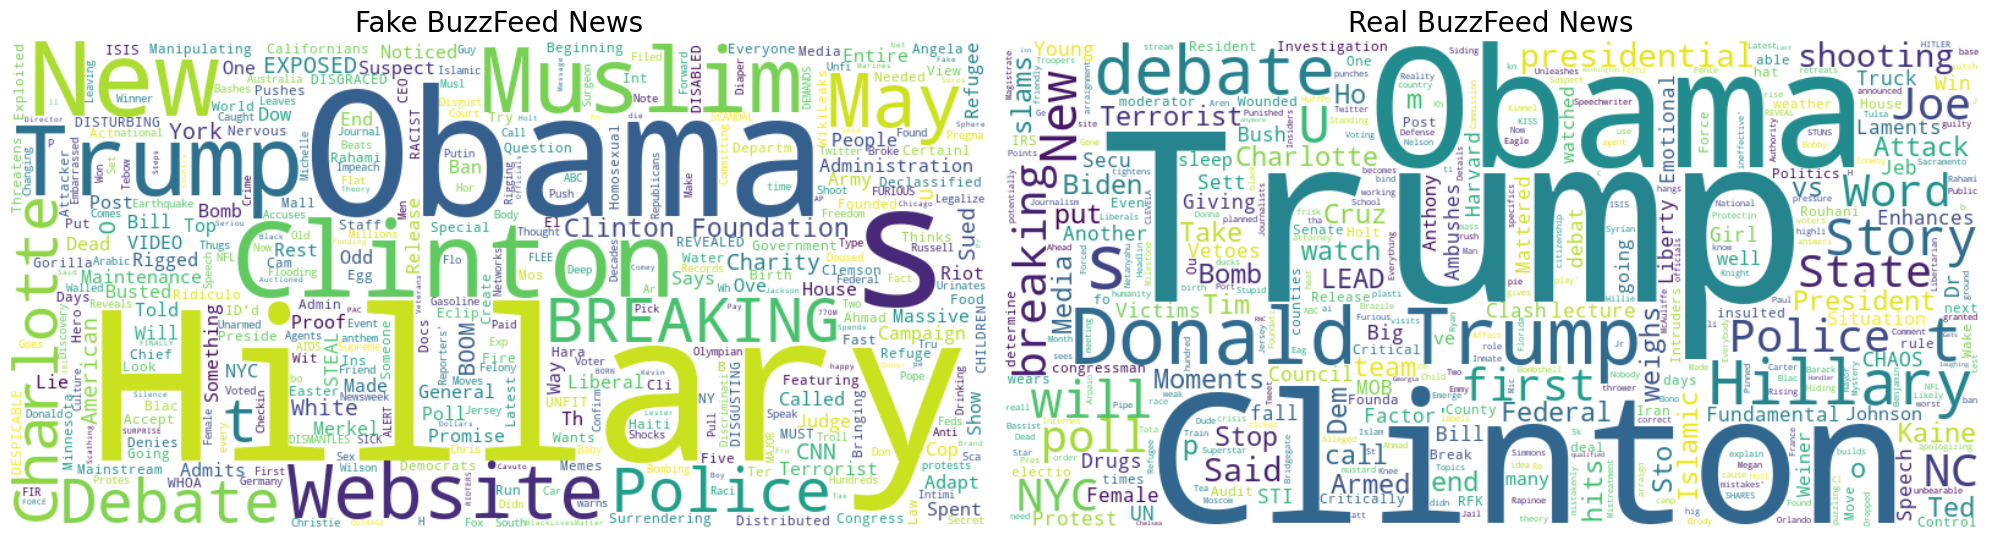

In [48]:
# Create word cloud for the fake news
from wordcloud import WordCloud
import matplotlib.pyplot as plt

df_fake["full_text"] = df_fake["title"] + " " + df_fake["text"]
df_real["full_text"] = df_real["title"] + " " + df_real["text"]

# Create a word cloud for the fake news
wordcloud_fake = WordCloud(background_color="white",
                           max_words=5000,
                           contour_width=3,
                           contour_color='steelblue',
                           width=800,  
                           height=400  
                          )
wordcloud_fake.generate(df_fake["full_text"].to_string())
wordcloud_fake.to_image()

# Create a word cloud for the real news
wordcloud_real = WordCloud(background_color="white",
                           max_words=5000,
                           contour_width=3,
                           contour_color='steelblue',
                           width=800,  
                           height=400  
                          )
wordcloud_real.generate(df_real["full_text"].to_string())
wordcloud_real.to_image()

# Set up the figure and axes
fig, axarr = plt.subplots(1, 2, figsize=(20, 10))  # 1x2 grid of plots, adjust the figure size as needed

# Display the fake news word cloud on the left subplot
axarr[0].imshow(wordcloud_fake, interpolation='bilinear')
axarr[0].axis('off')
axarr[0].set_title("Fake BuzzFeed News", fontsize=20)

# Display the real news word cloud on the right subplot
axarr[1].imshow(wordcloud_real, interpolation='bilinear')  # Make sure you're showing wordcloud_real here
axarr[1].axis('off')
axarr[1].set_title("Real BuzzFeed News", fontsize=20)

# Adjust the spacing between the plots if necessary
plt.tight_layout()

plt.savefig("../reports/figures/BuzzFeedwordcloud.png", bbox_inches='tight')

plt.show()

In [114]:
from sklearn.feature_extraction import DictVectorizer
# Convert the dictionaries in the "tfidf" column into a matrix
dict_vectorizer = DictVectorizer(sparse=False)
tfidf_matrix_train = dict_vectorizer.fit_transform(df_train['tfidf'])
tfidf_matrix_test = dict_vectorizer.transform(df_test['tfidf'])

# Normalize the train and test TF-IDF matrices
from sklearn.preprocessing import normalize
tfidf_matrix_train = normalize(tfidf_matrix_train)
tfidf_matrix_test = normalize(tfidf_matrix_test)

## Spectral Representation of the TF-IDF Matrix

In [129]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from scipy.sparse.linalg import eigsh
from scipy.sparse import csgraph

def compute_normalized_laplacian(similarity_matrix):
    """
    Compute the normalized Laplacian matrix from the similarity matrix.
    """
    laplacian = csgraph.laplacian(similarity_matrix, normed=True)
    return laplacian

def compute_eigenvectors(laplacian, n_clusters):
    """
    Compute the first k eigenvectors of the Laplacian matrix.
    """
    try:
        eigenvalues, eigenvectors = eigsh(laplacian, k=n_clusters, which='SM')
    except RuntimeError as e:
        raise ValueError("Error in eigendecomposition: " + str(e))
    
    return eigenvectors

def kmeans_clustering(eigenvectors, n_clusters):
    """
    Apply k-means clustering on the eigenvectors.
    """
    # Normalize the eigenvectors row-wise
    eigenvector_norms = np.linalg.norm(eigenvectors, axis=1, keepdims=True)
    eigenvectors_normalized = eigenvectors / eigenvector_norms

    # Run k-means on the normalized eigenvectors
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, max_iter=300, random_state=42)
    kmeans.fit(eigenvectors_normalized)
    return kmeans.labels_

def spectral_clustering(tf_idf_matrix, n_clusters):
    """
    Apply spectral clustering on TF-IDF data.
    :param tf_idf_matrix: The TF-IDF matrix of shape (n_samples, n_features).
    :param n_clusters: The number of clusters to form.
    :return: Cluster labels for each point.
    """
    if n_clusters <= 0:
        raise ValueError("n_clusters must be a positive integer")
    
    # Step 1: Create the similarity matrix using cosine similarity
    similarity_matrix = cosine_similarity(tf_idf_matrix)

    # Step 2: Compute the normalized Laplacian matrix
    laplacian = compute_normalized_laplacian(similarity_matrix)

    # Step 3: Compute the first k eigenvectors of the Laplacian
    eigenvectors = compute_eigenvectors(laplacian, n_clusters)

    # Step 4: Run k-means on the eigenvectors
    labels = kmeans_clustering(eigenvectors, n_clusters)

    return labels

# Usage example:
n_clusters = 3
cluster_labels = spectral_clustering(tfidf_matrix_train, n_clusters)
print(cluster_labels)


[1 1 1 2 0 0 0 0 1 0 1 0 0 1 0 2 1 2 2 1 2 1 1 1 1 2 1 0 0 0 0 0 0 0 1 1 0
 1 1 2 2 0 0 1 1 1 0 0 0 2 1 1 0 1 1 2 2 0 0 0 0 2 0 0 0 2 2 1 2 2 0 2 0 0
 2 2 2 1 0 2 1 1 1 2 0 1 1 1 1 2 2 1 1 1 2 1 1 1 0 2 2 1 2 1 1 0 1 1 1 1 2
 2 1 0 1 2 0 0 1 1 2 0 0 1 1 2 2 1 0 1 1 1 2 1 2 1 1 1 2 1 1 1 1 1 0 0]


In [130]:
df_train["cluster"] = cluster_labels

# Investigate the clusters distribution together with the labels
df_train.groupby(["cluster", "label"]).size().reset_index(name="count")

,cluster,label,count
0,0,0,13
1,0,1,31
2,1,0,40
3,1,1,25
4,2,0,20
5,2,1,17


## PCA

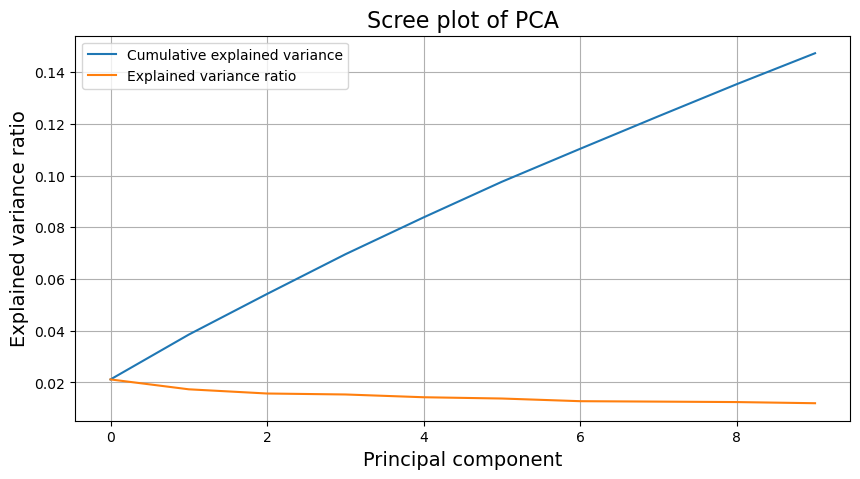

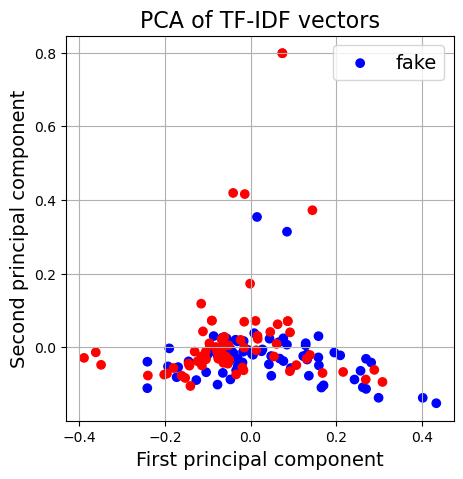

In [117]:
from sklearn.decomposition import PCA
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.offline import plot
from tqdm import tqdm


# Compute PCA of the TF-IDF vectors
pca = PCA(n_components=10)
pca.fit(tfidf_matrix_train)

# Transform the TF-IDF matrix using the PCA model
tfidf_train_pca = pca.transform(tfidf_matrix_train)

plt.figure(figsize=(10, 5))
#cumulative explained variance
plt.plot(pca.explained_variance_ratio_.cumsum(), label='Cumulative explained variance')
plt.plot(pca.explained_variance_ratio_, label = 'Explained variance ratio')
plt.legend()
plt.xlabel('Principal component', fontsize=14)
plt.ylabel('Explained variance ratio', fontsize=14)
plt.title('Scree plot of PCA', fontsize=16)
plt.grid(True)
plt.show()

# Create a scatter plot of the two first principal components
plt.figure(figsize=(5, 5))
plt.scatter(tfidf_train_pca[:, 0], tfidf_train_pca[:, 1], c=df_train['label'].map({0: 'red', 1: 'blue'}), cmap='coolwarm')
plt.xlabel('First principal component', fontsize=14)
plt.ylabel('Second principal component', fontsize=14)
plt.title('PCA of TF-IDF vectors', fontsize=16)
plt.grid(True)
plt.legend(['fake', 'real'], fontsize=14)
plt.show()

In [43]:
#Make an interactive 3D plot of the first three principal components
trace1 = go.Scatter3d(
    x=tfidf_train_pca[:, 0],
    y=tfidf_train_pca[:, 1],
    z=tfidf_train_pca[:, 2],
    mode='markers',
    marker=dict(
        size=6,
        color=df_train['label'].map({0: 'red', 1: 'blue'}),
        colorscale='Viridis',
        opacity=0.8
    )
)

data = [trace1]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)
fig = go.Figure(data=data, layout=layout)
plot(fig, filename='../reports/figures/BuzzFeedPCA.html')


'../reports/figures/BuzzFeedPCA.html'

In [48]:
tfidf_test_pca = pca.transform(tfidf_matrix_test)

## Implementation of Davies-Bouldin score


In [14]:
# Function to manually compute the Davies-Bouldin index

def davies_bouldin_index(X, labels):
    """Compute Davies-Bouldin index for a clustering solution.
    
    Parameters
    ----------
    X : array-like, shape (n_samples, n_features)
        List of n_features-dimensional data points. Each row corresponds to a single data point.
    labels : array-like, shape (n_samples,)
        Predicted labels for each sample.
    
    Returns
    -------
    float
        Davies-Bouldin index for the clustering solution.
    
    """
    # Compute cluster centroids
    centroids = [X[labels == i].mean(axis=0) for i in range(len(set(labels)))]
    
    # Compute cluster scatter matrices
    S = [np.sum((X[labels == i] - centroids[i])**2, axis=0) for i in range(len(set(labels)))]
    
    # Compute pairwise distance between cluster centroids
    M = np.array([np.sqrt(np.sum((centroids[i] - centroids[j])**2)) for i in range(len(centroids)) for j in range(len(centroids))]).reshape(len(centroids), len(centroids))
    
    # Compute Davies-Bouldin index
    DB = np.mean([(S[i] + S[j])/M[i, j] for i in range(len(S)) for j in range(len(S)) if j != i])
    
    return DB


### Implementation of the K-means clustering algorithm.


In [101]:
from sklearn.metrics.pairwise import euclidean_distances

class KMeans_clustering:
    def __init__(self, n_clusters=2, random_state=42, max_iter=100, tol=1e-4):
        """
        Initialize the KMeans clustering model.

        Parameters:
        n_clusters (int): The number of clusters to form.
        random_state (int): Determines random number generation for centroid initialization.
        max_iter (int): Maximum number of iterations of the k-means algorithm for a single run.
        tol (float): Relative tolerance with regards to inertia to declare convergence.
        """
        self.train_centroids = None
        self.n_clusters = n_clusters
        self.random_state = random_state
        self.max_iter = max_iter
        self.tol = tol
    
    def fit_predict(self, X):
        """
        Compute k-means clustering and predict the cluster index for each sample.

        Parameters:
        X (array-like): List of n_features-dimensional data points. Each row corresponds to a single data point.

        Returns:
        membership (list of int): Predicted cluster labels for each sample.
        """
        # Create a random number generator with a specific seed
        rng = np.random.RandomState(self.random_state)

        # Initialize cluster centroids
        old_centroids = X[rng.choice(range(len(X)), size=self.n_clusters, replace=False)]
        centroids = old_centroids.copy()

        # Initialize cluster labels
        cluster_labels = np.zeros(len(X))

        # Iterate until convergence or until max_iterations is reached
        for iteration in range(self.max_iter):
            print(f"Iteration {iteration + 1}")

            # Compute the distance between each data point and each centroid
            distances = euclidean_distances(X, centroids)

            # Assign each data point to the closest centroid
            new_cluster_labels = np.argmin(distances, axis=1)

            # Update the centroids and reinitialize empty clusters
            for c in range(self.n_clusters):
                if len(X[new_cluster_labels == c]) > 0:
                    centroids[c] = X[new_cluster_labels == c].mean(axis=0)
                else:  # reinitialize empty cluster
                    centroids[c] = X[rng.choice(range(len(X)))]

            # Check for convergence
            if np.sum((centroids - old_centroids)**2) < self.tol:
                break

            # Update the membership matrix and old centroids
            old_centroids = centroids.copy()
            cluster_labels = new_cluster_labels

        self.train_centroids = centroids

        return cluster_labels
    
    def predict(self, X):
        """Predict cluster labels for new data points.
        
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            List of n_features-dimensional data points. Each row corresponds to a single data point.
        
        Returns
        -------
        list of int
            Predicted cluster labels for each sample.
        
        """
        # Compute pairwise distances between data points and cluster centroids
        distances = np.array([np.sqrt(np.sum((X - centroid)**2, axis=1)) for centroid in self.train_centroids])
        
        # Assign cluster labels
        cluster_labels = np.argmin(distances, axis=0)
        
        return cluster_labels

In [102]:
cls = KMeans_clustering(n_clusters=2, random_state=43, max_iter=100)

train_clusters = cls.fit_predict(tfidf_matrix_train)

# Check the clustering distribution compared with the label distribution
print(Counter(train_clusters))

# Check the label distribution within each cluster
df_train['cluster'] = train_clusters
df_train.groupby(['cluster', 'label']).size()


Iteration 1
Iteration 2
Counter({0: 108, 1: 38})


cluster  label
0        0        55
         1        53
1        0        18
         1        20
dtype: int64

In [103]:
# Build a random forest classifier on the KMeans clusters and compare with a classifier on the original data
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Build a random forest classifier on the original data
rf_original = RandomForestClassifier(random_state=42)
rf_original.fit(tfidf_matrix_train, df_train['label'])
pred_original = rf_original.predict(tfidf_matrix_test)
print(f"Accuracy on the original data: {accuracy_score(df_test['label'], pred_original)}")

# Predict the cluster for each data point in the test set
test_clusters = cls.predict(tfidf_matrix_test)

df_test['cluster'] = test_clusters

# Build a random forest classifier on each cluster
rf_clusters = []
pred_clusters = []
results = []

for cluster in range(2):
    # Get the indices of the data points in the cluster
    cluster_train_indices = df_train[df_train['cluster'] == cluster].index
    
    # Build a random forest classifier on the cluster
    rf_cluster = RandomForestClassifier(random_state=42)
    rf_cluster.fit(tfidf_matrix_train[cluster_train_indices], df_train.loc[cluster_train_indices, 'label'])
    rf_clusters.append(rf_cluster)
    
    # Make predictions on the test data after assigning each data point to the closest cluster
    cluster_test_indices = df_test[df_test['cluster'] == cluster].index
    pred_cluster = rf_cluster.predict(tfidf_matrix_test[cluster_test_indices])
    pred_clusters.append(pred_cluster)
    
    result = pred_cluster == df_test.loc[cluster_test_indices, 'label']
    results.append(result)

# Compute the overall accuracy 
print(f"Accuracy on the clustered data: {np.mean(np.concatenate(results))}")



Accuracy on the original data: 0.6111111111111112
Accuracy on the clustered data: 0.6388888888888888


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from collections import Counter

# Initialize lists to store accuracies
original_accuracies = []
clustered_accuracies = []

# Repeat the experiment 20 times
for i in range(20):
    # Build a random forest classifier on the original data
    rf_original = RandomForestClassifier()
    rf_original.fit(tfidf_matrix_train, df_train['label'])
    pred_original = rf_original.predict(tfidf_matrix_test)
    original_accuracies.append(accuracy_score(df_test['label'], pred_original))

    # Perform clustering
    cls = KMeans_clustering(n_clusters=2, max_iter=100)
    train_clusters = cls.fit_predict(tfidf_matrix_train)
    df_train['cluster'] = train_clusters

    # Predict the cluster for each data point in the test set
    test_clusters = cls.predict(tfidf_matrix_test)
    df_test['cluster'] = test_clusters

    # Build a random forest classifier on each cluster
    rf_clusters = []
    pred_clusters = []
    results = []

    for cluster in range(2):
        # Get the indices of the data points in the cluster
        cluster_train_indices = df_train[df_train['cluster'] == cluster].index
        
        # Build a random forest classifier on the cluster
        rf_cluster = RandomForestClassifier()
        rf_cluster.fit(tfidf_matrix_train[cluster_train_indices], df_train.loc[cluster_train_indices, 'label'])
        rf_clusters.append(rf_cluster)
        
        # Make predictions on the test data after assigning each data point to the closest cluster
        cluster_test_indices = df_test[df_test['cluster'] == cluster].index
        pred_cluster = rf_cluster.predict(tfidf_matrix_test[cluster_test_indices])
        pred_clusters.append(pred_cluster)
        
        result = pred_cluster == df_test.loc[cluster_test_indices, 'label']
        results.append(result)

    # Compute the overall accuracy 
    clustered_accuracies.append(np.mean(np.concatenate(results)))

# Print the average accuracies
print(f"Average accuracy on the original data: {np.mean(original_accuracies)}")
print(f"Average accuracy on the clustered data: {np.mean(clustered_accuracies)}")

## Repeat experiment 20 times

In [105]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from collections import Counter

# Initialize lists to store accuracies
original_accuracies = []
clustered_accuracies = []

# Repeat the experiment 20 times
for i in range(20):
    # Build a random forest classifier on the original data
    rf_original = RandomForestClassifier(random_state=i)
    rf_original.fit(tfidf_matrix_train, df_train['label'])
    pred_original = rf_original.predict(tfidf_matrix_test)
    original_accuracies.append(accuracy_score(df_test['label'], pred_original))

    # Perform clustering
    cls = KMeans_clustering(n_clusters=2, random_state=i, max_iter=100)
    train_clusters = cls.fit_predict(tfidf_matrix_train)
    df_train['cluster'] = train_clusters

    # Predict the cluster for each data point in the test set
    test_clusters = cls.predict(tfidf_matrix_test)
    df_test['cluster'] = test_clusters

    # Build a random forest classifier on each cluster
    rf_clusters = []
    pred_clusters = []
    results = []

    for cluster in range(2):
        # Get the indices of the data points in the cluster
        cluster_train_indices = df_train[df_train['cluster'] == cluster].index
        
        # Build a random forest classifier on the cluster
        rf_cluster = RandomForestClassifier(random_state=i)
        rf_cluster.fit(tfidf_matrix_train[cluster_train_indices], df_train.loc[cluster_train_indices, 'label'])
        rf_clusters.append(rf_cluster)
        
        # Make predictions on the test data after assigning each data point to the closest cluster
        cluster_test_indices = df_test[df_test['cluster'] == cluster].index
        if len(cluster_test_indices) > 0:  # Check if there are any test samples in the cluster
            pred_cluster = rf_cluster.predict(tfidf_matrix_test[cluster_test_indices])
            pred_clusters.append(pred_cluster)
            
            result = pred_cluster == df_test.loc[cluster_test_indices, 'label']
            results.append(result)

    # Compute the overall accuracy 
    clustered_accuracies.append(np.mean(np.concatenate(results)))

# Print the average accuracies
print(f"Average accuracy on the original data: {np.mean(original_accuracies)}")
print(f"Average accuracy on the clustered data: {np.mean(clustered_accuracies)}")

Iteration 1
Iteration 2
Iteration 1
Iteration 2
Iteration 1
Iteration 2
Iteration 3
Iteration 1
Iteration 2
Iteration 1
Iteration 2
Iteration 3
Iteration 1
Iteration 2
Iteration 3
Iteration 1
Iteration 2
Iteration 3
Iteration 1
Iteration 2
Iteration 3
Iteration 1
Iteration 2
Iteration 3
Iteration 1
Iteration 2
Iteration 3
Iteration 1
Iteration 2
Iteration 1
Iteration 2
Iteration 3
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 1
Iteration 2
Iteration 1
Iteration 2
Iteration 3
Iteration 1
Iteration 2
Iteration 3
Iteration 1
Iteration 2
Iteration 1
Iteration 2
Iteration 1
Iteration 2
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Average accuracy on the original data: 0.7027777777777777
Average accuracy on the clustered data: 0.6722222222222223


In [28]:
def k_means(X, k_values=range(2, 5), max_iterations=100):
    """
    Performs k-means clustering on the given data using the best k value for clustering based on the Davies-Bouldin score.
    
    Parameters:
    X (numpy.ndarray): The data to cluster.
    k_values (range): The range of k values to test.
    max_iterations (int): The maximum number of iterations to run the clustering algorithm.
    
    Returns:
    numpy.ndarray: The membership matrix indicating which cluster each data point belongs to.
    """
    db_scores = []

    for k in tqdm(k_values):
        # Initialize the centroids randomly from the data points
        n = X.shape[0]
        centroids = X[np.random.randint(0, n, k)]

        # Initialize the membership matrix randomly
        membership = np.zeros(n)

        # Iterate until convergence or until max_iterations is reached
        for iteration in range(max_iterations):
            # Compute the distance between each data point and each centroid
            distances = np.array([np.linalg.norm(X - centroid, axis=1) for centroid in centroids])

            # Assign each data point to the closest centroid
            new_membership = np.argmin(distances, axis=0)

            # If no point changed membership, stop the iteration
            if np.array_equal(membership, new_membership):
                break

            # Update the membership matrix
            membership = new_membership

            # Update the centroids
            centroids = np.array([X[membership == c].mean(axis=0) for c in range(k)])

        # Check if there are at least two unique clusters
        if len(np.unique(membership)) > 1:
            # Compute Davies-Bouldin score
            db_score = davies_bouldin_index(X, membership)
            db_scores.append(db_score)
        else:
            # If not, append a high score to indicate poor clustering
            db_scores.append(float('inf'))

    # Choose the k with the lowest Davies-Bouldin score
    best_k = k_values[np.argmin(db_scores)]

    # Perform k-means clustering with the best k value
    n = X.shape[0]
    centroids = X[np.random.randint(0, n, best_k)]
    membership = np.zeros(n)
    for iteration in range(max_iterations):
        distances = np.array([np.linalg.norm(X - centroid, axis=1) for centroid in centroids])
        new_membership = np.argmin(distances, axis=0)
        if np.array_equal(membership, new_membership):
            break
        membership = new_membership
        centroids = np.array([X[membership == c].mean(axis=0) for c in range(best_k)])

    return best_k, membership

In [29]:
k_means(tfidf_matrix_train)

100%|██████████| 3/3 [00:00<00:00,  4.21it/s]


(4,
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64))

In [54]:
cls = KMeans()
labels = cls.fit_predict(tfidf_train_pca)




Iteration 1
Iteration 2
Iteration 3


In [55]:
labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [56]:
cls.predict(tfidf_test_pca)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

## k-Means clustering used for classification

In [14]:
best_k, memberships = k_means(tfidf_matrix_train, (2,4), max_iterations=100)
print(best_k, Counter(memberships))

100%|██████████| 2/2 [00:00<00:00,  7.82it/s]

2 Counter({0: 145, 1: 1})


## Random Forrest Classification of the TF-IDF representation

In [74]:
# Random forrest classification of the tf-idf representation in the tf_idf matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, classification_report

# Create a random forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier
rf.fit(tfidf_matrix_train, df_train['label'])

# Make predictions on the test data
predictions = rf.predict(tfidf_matrix_test)

print(f"Accuracy: {np.mean(predictions == df_test['label'])}")
print(f"F1 score 'fake': {f1_score(df_test['label'], predictions, pos_label=0)}")
print(f"F1 score 'real': {f1_score(df_test['label'], predictions, pos_label=1)}")
print(f"Precision 'fake': {precision_score(df_test['label'], predictions, pos_label=0)}")
print(f"Precision 'real': {precision_score(df_test['label'], predictions, pos_label=1)}")
print(f"Recall 'fake': {recall_score(df_test['label'], predictions, pos_label=0)}")
print(f"Recall 'real': {recall_score(df_test['label'], predictions, pos_label=1)}")

# Classification report
print(classification_report(df_test['label'], predictions))


Accuracy: 0.6111111111111112
F1 score 'fake': 0.65
F1 score 'real': 0.5625000000000001
Precision 'fake': 0.5909090909090909
Precision 'real': 0.6428571428571429
Recall 'fake': 0.7222222222222222
Recall 'real': 0.5
              precision    recall  f1-score   support

           0       0.59      0.72      0.65        18
           1       0.64      0.50      0.56        18

    accuracy                           0.61        36
   macro avg       0.62      0.61      0.61        36
weighted avg       0.62      0.61      0.61        36



## Linear Discriminant Analysis

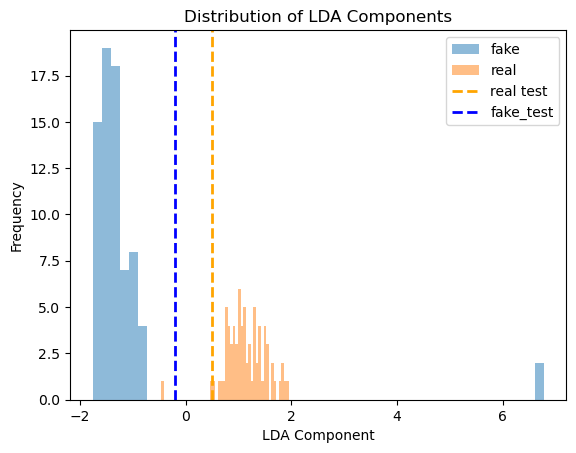

In [16]:
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Fit LDA model and transform data
clf = LinearDiscriminantAnalysis()
clf.fit(tfidf_matrix_train, df_train["label"])
X = clf.fit_transform(tfidf_matrix_train, df_train["label"])

# Project one real article and one fake article from the test set onto the LDA component

# Get the row numbers of the real and fake articles in the test set
real_row = df_test[df_test["label"] == 1].iloc[17].name
fake_row = df_test[df_test["label"] == 0].iloc[17].name

# Transform the TF-IDF vectors of the real and fake articles
real_tfidf = tfidf_matrix_test[real_row]
fake_tfidf = tfidf_matrix_test[fake_row]
real_lda = clf.transform(real_tfidf.reshape(1, -1))
fake_lda = clf.transform(fake_tfidf.reshape(1, -1))

# Plot histogram of X values
plt.hist(X[df_train["label"] == 0], bins=50, alpha=0.5, label="fake")
plt.hist(X[df_train["label"] == 1], bins=50, alpha=0.5, label="real")
plt.axvline(x=real_lda, color='orange', linestyle='dashed', linewidth=2, label="real test")
plt.axvline(x=fake_lda, color='blue', linestyle='dashed', linewidth=2, label="fake_test")
plt.xlabel('LDA Component')
plt.ylabel('Frequency')
plt.title('Distribution of LDA Components')
plt.legend()
plt.show()

Accuracy: 0.6944444444444444


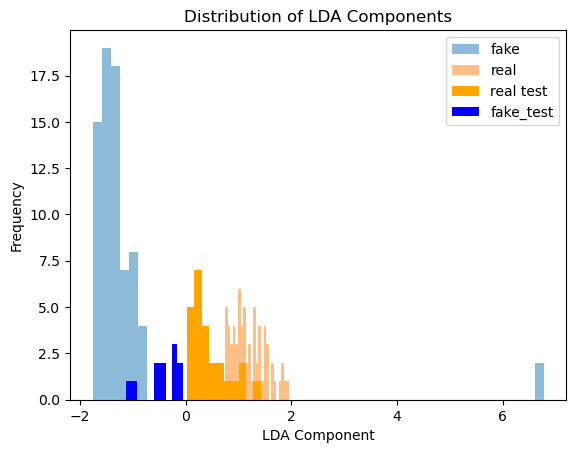

In [17]:
# Fit LDA model and transform data
clf = LinearDiscriminantAnalysis()
clf.fit(tfidf_matrix_train, df_train["label"])
X = clf.fit_transform(tfidf_matrix_train, df_train["label"])

# Transform the TF-IDF vectors of the real and fake articles in the test set
X_test = clf.transform(tfidf_matrix_test)

# Predict the labels of the test set
y_pred = clf.predict(tfidf_matrix_test)

# Calculate the accuracy of the prediction
accuracy = np.mean((df_test["label"] == y_pred))
print("Accuracy:", accuracy)

# Plot histogram of X values
plt.hist(X[df_train["label"] == 0], bins=50, alpha=0.5, label="fake")
plt.hist(X[df_train["label"] == 1], bins=50, alpha=0.5, label="real")
plt.hist(X_test[y_pred == 1],  color='orange', linestyle='dashed', linewidth=2, label="real test")
plt.hist(X_test[y_pred == 0], color='blue', linestyle='dashed', linewidth=2, label="fake_test")
plt.xlabel('LDA Component')
plt.ylabel('Frequency')
plt.title('Distribution of LDA Components')
plt.legend()
plt.show()